# Práctica 2

Procesamiento de Lenguaje Natural
Facultad de Ingeniería, UNAM

González Flores Andrés

## Instrucciones

A partir del corpus proporcionado ("corpusML.txt") realizar un modelo del lenguaje neuronal con base en la arquitectura propuesta por Bengio (2003).

Síganse los siguientes pasos:

1. Limpiar los textos y aplicar stemming a las palabras.
2. Insertar símbolos de inicio y final de cadena.
3. Obtener los bigramas que aparecen en el texto (indexar numéricamente).
4. Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).
5. Obtener las matrices $A$ y $\Pi$ a partir de las salidas de la red neuornal (probabilidad Softmax).
6. Evaluar el modelo (con Entropía).
7. Calcular la proabilidad de las siguientes oraciones:
    - Nos bañamos con agua caliente
    - El animalito le olía la cabeza
    - Pascuala ordeñaba las vacas

## Desarrollo

In [1]:
# Importar módulos
import numpy as np
import re
from nltk import SnowballStemmer
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import chain

In [17]:
# Definición de constantes
np.random.seed(42)
stemmer_esp = SnowballStemmer('spanish')
CORPUS_PATH = './Data/corpusML.txt'
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<unk>'

### Paso 1

Limpiar los textos y aplicar stemming a las palabras.

In [3]:
with open(CORPUS_PATH, 'r', encoding='utf-8') as f:
    corpus = [
        list(map(lambda token: stemmer_esp.stem(token), # Mapeo cada token a su stem
            re.findall('[a-zA-zñáéíóúü]+', linea.lower()) # Devuelve una lista con todas las ocurrencias que coincidan con la regex
        ))
        for linea in f
    ]
    for docs in corpus[:5]:
        print(docs) # Muestro 5 ejemplos

['comenc', 'a', 'trabaj', 'y', 'me', 'peg', 'me', 'maltrat', 'con', 'chicot']
['mis', 'patron', 'me', 'peg', 'porqu', 'no', 'me', 'quer', 'apur', 'porqu', 'era', 'floj']
['por', 'eso', 'me', 'hab', 'peg']
['cuand', 'me', 'peg', 'ya', 'entonc', 'me', 'quit']
['pues', 'entonc', 'no', 'quis', 'trabaj']


Divido el corpus en entrenamiento y evaluación

In [4]:
train_corpus, eval_corpus = train_test_split(corpus, test_size=0.3)

print(f'\nTamaño del corpus de entrenamiento: {len(train_corpus)}')
print('Ejemplos:')
for docs in train_corpus[:5]:
        print(docs) # Muestro 5 ejemplos

print(f'\nTamaño del corpus de evaluación: {len(eval_corpus)}')
print('Ejemplos:')
for docs in eval_corpus[:5]:
        print(' ', docs) # Muestro 5 ejemplos


Tamaño del corpus de entrenamiento: 751
Ejemplos:
['por', 'eso', 'me', 'hab', 'peg']
['y', 'este', 'pues', 'sol', 'eso', 'trabaj']
['pues', 'nos', 'acab', 'la', 'carn']
['pues', 'fabric', 'una', 'man', 'verd']
['ordeñ', 'las', 'vac', 'cuatr', 'o', 'cinc', 'vac']

Tamaño del corpus de evaluación: 323
Ejemplos:
  ['nomas', 'estab', 'chic', 'mis', 'herman']
  ['jug', 'el', 'alla', 'en', 'el', 'camp']
  ['y', 'este', 'termin', 'de', 'tron', 'se', 'recog', 'y', 'se', 'troz']
  ['tambien', 'el', 'metat', 'es', 'trabaj']
  ['no', 'pod', 'com', 'mi', 'tortill']


Muestro la curva de zipf

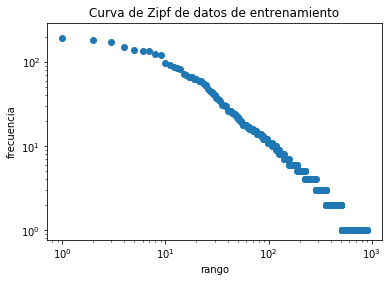

In [5]:
frec = sum([Counter(doc) for doc in train_corpus], Counter())

plt.plot(sorted(frec.values(), reverse=True), 'o')
plt.xlabel('rango')
plt.ylabel('frecuencia')
plt.xscale('log')
plt.yscale('log')
plt.title('Curva de Zipf de datos de entrenamiento')
plt.show()

Sustituyo los hapax por el identificador <unk\>

In [6]:
train_corpus_unk = [
    [
        # Si la frecuencia de la palabra es 1, se sustituye por UNK
        (UNK if frec[w] == 1 else w)
        for w in doc
    ] 
    for doc in train_corpus 
]

print('Ejemplos:')
for docs in train_corpus_unk[:5]:
        print(docs) # Muestro 5 ejemplos

Ejemplos:
['por', 'eso', 'me', 'hab', 'peg']
['y', 'este', 'pues', 'sol', 'eso', 'trabaj']
['pues', 'nos', 'acab', 'la', 'carn']
['pues', 'fabric', 'una', 'man', 'verd']
['ordeñ', 'las', 'vac', 'cuatr', 'o', 'cinc', 'vac']


### Paso 2

Insertar símbolos de inicio y final de cadena.

In [7]:
train_corpus_unk = list(map(lambda doc: [BOS, *doc, EOS], train_corpus_unk))
for doc in train_corpus_unk[:5]:
    print(doc)

['<BOS>', 'por', 'eso', 'me', 'hab', 'peg', '<EOS>']
['<BOS>', 'y', 'este', 'pues', 'sol', 'eso', 'trabaj', '<EOS>']
['<BOS>', 'pues', 'nos', 'acab', 'la', 'carn', '<EOS>']
['<BOS>', 'pues', 'fabric', 'una', 'man', 'verd', '<EOS>']
['<BOS>', 'ordeñ', 'las', 'vac', 'cuatr', 'o', 'cinc', 'vac', '<EOS>']


### Paso 3

Obtener los bigramas que aparecen en el texto (indexar numéricamente).

In [8]:
# Indexo numéricamente los stems
vocab = defaultdict() 
# El método default_factory sirve para asignar un nuevo valor por defecto
# en caso de no encontrar el indice dado
vocab.default_factory = lambda: len(vocab)

# Indexo numéricamente las palabras en los documentos
corpus_ids = [[vocab[w] for w in doc] for doc in train_corpus_unk]

print('Ejemplos de palabras en el vocabulario')
for palabra, i in list(vocab.items())[:10]:
    print(f'  {palabra} : {i}')

print('\nEjemplos de oraciones indexadas numéricamente')
for doc in corpus_ids[:6]:
    print(' ', doc)

Ejemplos de palabras en el vocabulario
  <BOS> : 0
  por : 1
  eso : 2
  me : 3
  hab : 4
  peg : 5
  <EOS> : 6
  y : 7
  este : 8
  pues : 9

Ejemplos de oraciones indexadas numéricamente
  [0, 1, 2, 3, 4, 5, 6]
  [0, 7, 8, 9, 10, 2, 11, 6]
  [0, 9, 12, 13, 14, 15, 6]
  [0, 9, 16, 17, 18, 19, 6]
  [0, 20, 21, 22, 23, 24, 25, 22, 6]
  [0, 26, 7, 27, 28, 9, 29, 30, 14, 31, 6]


In [9]:
inv_vocab = { item : key for key, item in vocab.items()}

```doc[:-1]``` toma todos las cadenas de un documento (frase) excepto la última

```doc[1:]``` toma todos las cadenas de un documento (frase) excepto la primera

Con zip, uno una cadena de la primer lista con una de la segunda en tuplas (bigramas)

In [10]:
bigramas = [bi for doc in train_corpus_unk for bi in zip(doc[:-1], doc[1:])]

bigramas[:20] # Ejemplos con cadenas

[('<BOS>', 'por'),
 ('por', 'eso'),
 ('eso', 'me'),
 ('me', 'hab'),
 ('hab', 'peg'),
 ('peg', '<EOS>'),
 ('<BOS>', 'y'),
 ('y', 'este'),
 ('este', 'pues'),
 ('pues', 'sol'),
 ('sol', 'eso'),
 ('eso', 'trabaj'),
 ('trabaj', '<EOS>'),
 ('<BOS>', 'pues'),
 ('pues', 'nos'),
 ('nos', 'acab'),
 ('acab', 'la'),
 ('la', 'carn'),
 ('carn', '<EOS>'),
 ('<BOS>', 'pues')]

In [11]:
bigramas_ids = [bi for doc in corpus_ids for bi in zip(doc[:-1], doc[1:])]
bigramas_ids[:20] # Ejemplos de bigramas indexados numéricamente

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (0, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 2),
 (2, 11),
 (11, 6),
 (0, 9),
 (9, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 6),
 (0, 9)]

### Paso 4

Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).

In [61]:
# Hiperparámetros
d = 100
m = 300
iterac = 50
lr = 0.1
# Constantes
N = len(vocab)

In [15]:
class Bengio2003:
    m = 10
    d = 2
    N = 0
    bigramas_ids = []
    C_1 = []
    C_2 = []
    b_2 = []
    U = []
    c = []
    def __init__(self, bigramas_ids, d, m):
        self.d = d
        self.m = m
        self.N = len(bigramas_ids)
        self.bigramas_ids = bigramas_ids

    def inicializar_pesos(self):
        C_1 = np.random.random((d, N))
        C_2 = np.random.random((m, d))
        b_2 = np.random.random(m)
        U = np.random.random((N, m))
        c = np.random.random(N)
    
    def forward(self, bigrama):
        i_x = bigrama[0] # El índice de la primer palabra del bigrama
        y = bigrama[1] # El índice de la segunda palabra del bigrama
        # La capa embedding se reduce a C_1[:, i_x]
        h = np.math.tanh(np.dot(C_2, C_1[:, i_x]) + b_2) # Segunda capa oculta
        a = np.dot(U, h) + c # Preactivación
        exp_a = np.exp(a) # Exponencial de la preactivación
        return (exp_a/np.sum(exp_a), a, h) # Capa de salida softmax

    def backprop(self, y_pred, y):
        # Backprop
        d_out = np.array(salida) #.reshape(N, 1)
        d_out[y_pred] -= 1  # p(w_k | w_i) - y_k
        d_h = (1-h**2)*np.dot( d_out.T, U)
        d_c = np.dot(d_h.T, W)

        # Actualizamos los pesos
        U -= lr*d_out.reshape(N, 1)*h.reshape(1, m)
        c -= lr*d_out
        W -= lr*d_h.reshape(m, 1)*C[:,i_x].reshape(1,d)
        b -= d_h
        C[:, i_x] -= lr*d_c # Las demás filas no nos interesan, porque son 0
    
    def f_costo(self):
        return 
    
    def entrenar(self):
        pass

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

Defino la matriz de la primer capa oculta (embedding). $ C \in \mathbb{R}^{d \times N} $.

In [56]:
C = np.random.random((d, N))

Defino la matriz de la segunda capa oculta. 

In [57]:
W = np.random.random((m, d))
b = np.random.random(m)

Defino la matriz de la capa de salida

In [58]:
U = np.random.random((N, m))
c = np.random.random(N)

In [63]:
bigrama = bigramas_ids[0]

i_x = bigrama[0] # El índice de la primer palabra del bigrama
y = bigrama[1] # El índice de la segunda palabra del bigrama
# La capa embedding se reduce a C_1[:, i_x]
h = np.tanh(np.dot(W, C[:, i_x]) + b) # Segunda capa oculta
a = np.dot(U, h) + c # Preactivación
exp_a = np.exp(a) # Exponencial de la preactivación
salida = exp_a/np.sum(exp_a) # Capa de salida softmax
y_pred = np.argmax(salida)

# Backprop
d_out = np.array(salida) #.reshape(N, 1)
d_out[y_pred] -= 1  # p(w_k | w_i) - y_k
d_h = (1-h**2)*np.dot( d_out.T, U)
d_c = np.dot(d_h.T, W)

# Actualizamos los pesos
U -= lr*d_out.reshape(N, 1)*h.reshape(1, m)
c -= lr*d_out
W -= lr*d_h.reshape(m, 1)*C[:,i_x].reshape(1,d)
b -= d_h
C[:, i_x] -= lr*d_c # Las demás filas no nos interesan, porque son 0



# d_out[y_pred] -= 1 # Actualizamos el indice de la palabra que vimos
# d_h = np.dot([1-h**2], np.sum(np.dot(d_out, U)))
# d_c = np.sum(np.dot(C_1, d_h))
# d_c

array([[0.02004335, 0.48716799, 0.3207828 , ..., 0.50386572, 0.53732753,
        0.35644763],
       [0.98151919, 0.86126559, 0.37983448, ..., 0.74425668, 0.23105028,
        0.06080416],
       [0.19688303, 0.41072543, 0.01543542, ..., 0.74897398, 0.4881148 ,
        0.94255316],
       ...,
       [0.01082942, 0.79101749, 0.50855421, ..., 0.83834314, 0.63047658,
        0.9347368 ],
       [0.46254564, 0.71267662, 0.40296255, ..., 0.25394607, 0.1973345 ,
        0.17833852],
       [0.94629902, 0.77000357, 0.07143664, ..., 0.29329633, 0.48374934,
        0.47713624]])

In [54]:
print(np.dot( d_out.T, U).shape)
# print(d_out.shape)
print(U.shape)

(300,)
(513, 300)


In [87]:
# (lr*d_out.reshape(N,1)*h.reshape(1, m)).shape
# (lr*d_h.reshape(m, 1)*C[:,i_x].reshape(1,d)).shape
# C[i_x] -= (lr*d_c.reshape(d, 1)*x.reshape(1,n)).shape
d_out.shape

(513,)

In [88]:
np.dot(d_out.reshape(N,1), h.reshape(1, m)).shape
# np.dot(h.T, d_out).shape

(513, 300)

In [85]:
# W.shape
C[:,500].shape

(100,)

In [50]:

# np.dot(U[y_pred], d_out)
print(U[:5,:5])
print((d_out.reshape(N, 1) * h.reshape(1, m))[:5,:5])

[[0.8521674  0.46924574 0.67566001 0.86996629 0.70951898]
 [0.65642743 0.24748766 0.22169943 0.72332663 0.9762052 ]
 [0.51533426 0.82602171 0.8228892  0.58609216 0.37992083]
 [0.46798472 0.14846082 0.63793933 0.83925569 0.19452547]
 [0.73977964 0.07260144 0.55099518 0.30339021 0.43607307]]
[[1.46918059e-02 1.46918059e-02 1.46918059e-02 1.46918059e-02
  1.46918059e-02]
 [3.47215550e-05 3.47215550e-05 3.47215550e-05 3.47215550e-05
  3.47215550e-05]
 [1.92430802e-09 1.92430802e-09 1.92430802e-09 1.92430802e-09
  1.92430802e-09]
 [2.42959879e-06 2.42959879e-06 2.42959879e-06 2.42959879e-06
  2.42959879e-06]
 [1.39447895e-06 1.39447895e-06 1.39447895e-06 1.39447895e-06
  1.39447895e-06]]


In [40]:
np.random.shuffle(bigramas_ids)
for i in range(iterac):
    for bigrama in bigramas_ids:
        # Forward
        i_x = bigrama[0] # El índice de la primer palabra del bigrama
        y = bigrama[1] # El índice de la segunda palabra del bigrama
        # La capa embedding se reduce a C_1[:, i_x]
        h = np.tanh(np.dot(C_2, C_1[:, i_x]) + b_2) # Segunda capa oculta
        a = np.dot(U, h) + c # Preactivación
        exp_a = np.exp(a) # Exponencial de la preactivación
        salida = exp_a/np.sum(exp_a) # Capa de salida softmax
        d_out
        # Backprop


NameError: name 'iterac' is not defined

In [75]:
d_out = np.array(salida).reshape(N, 1)
d_out[0] -= dout[]

array([7.30732953e-08])

In [39]:
-np.sum(np.sum(np.dot(np.log(salida))))

500

In [80]:
y_pred

372

In [83]:
inv_vocab = { item : key for key, item in vocab.items()}

In [85]:
inv_vocab[96]

'muj'